In [13]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from statsmodels.tsa.seasonal import seasonal_decompose

# Analisando Dataset de consumo de energia!

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error


sns.set_style()
%matplotlib inline
%config InlineBackend.figure_format = 'svg'


In [3]:
dataset_path = "./Electric_Production.csv"
df = pd.read_csv(dataset_path)
df.head()

,DATE,Value
0,01-01-1985,72.5052
1,02-01-1985,70.6720
2,03-01-1985,62.4502
3,04-01-1985,57.4714
4,05-01-1985,55.3151


In [4]:
df.dtypes

DATE      object
Value    float64
dtype: object

Converter Coluna DATE para o tipo de dado datetime

In [5]:
df.index = pd.to_datetime(df.DATE, format="%m-%d-%Y")

Eliminar a coluna DATE

In [6]:
df.drop("DATE",axis=1,inplace=True)


In [7]:
df.head()

,Value
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


# Validando se meu Dataset é uma Série Estacionária:

Uma TS é chamada de estácionária caso possua suas propriedades estatísticas sejam constantes em relação ao tempo.
Critérios básicos:
* Média constante em relação ao tempo;
* Variância constante em relação ao tempo;
* Covariância constante em relação ao tempo;

## Testando TS com Augmented Dickey-Fuller (ADF)
Este teste tem a capacidade de nos dizer se nossa série temporal é estacionária ou se não é!

### Carregando o Dataset

In [9]:
from statsmodels.tsa.stattools import adfuller
df_est = pd.read_csv(dataset_path,index_col=0,squeeze=True)

### Extraindo apenas os valores

In [10]:
X = df_est.values

### Aplicando o ADF:

In [15]:
result = adfuller(X)
print('-----Dickey-Fuller Aumentado:-----')
print('Teste Estatístico: {:.4f}'.format(result[0]))
print('Valor-P: {:.4f}'.format(result[1]))
print('Valores Críticos:')
for k, v in result[4].items():
    print('\t{}: {:.4f}'.format(k,v))

-----Dickey-Fuller Aumentado:-----
Teste Estatístico: -2.2570
Valor-P: 0.1862
Valores Críticos:
	1%: -3.4476
	5%: -2.8692
	10%: -2.5708


Nesse caso, com base no valor-p (0.1862), entendemos que essa série não é estacionária, pois para que ela fosse estacionária precisaria ser menor ou igual a 0.05!

## Transformando Dataset em uma TS Estacionária para poder aplicar análises de forecasting:

## Aplicando Técnicas de Forecasting:

### Naive Approach:
Nesse modelo a previsão Pt+1 é apenas uma mera observação do período imefiatamente anterior Pt.
Por isso temos a seguinte premissa: "O futuro repetirá o passado!", mesmo que essa técnica pareça algo completamente ingênuo, serve como benchmark, uma baseline inicial...

Dividindo Dataset em **treino** e **validação**:

In [17]:
train = df[df.index <= '2012-8-1']
valid = df[df.index > '2012-8-1']

Criando um dataframe para armazenar as previsões:

In [18]:
y_hat = valid.copy()

Copiando o último valor do dataset de treino e atribuindo à y_hat['naive']

In [19]:
y_hat['naive'] = train.iloc[-1].values[0]

Exibindo train e valid:

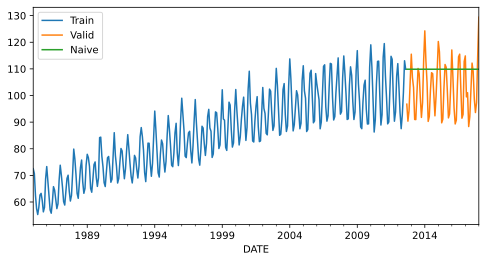

In [20]:
fig,ax = plt.subplots(figsize=(8,4))
train.plot(ax=ax)
valid.plot(ax=ax)
y_hat['naive'].plot(ax=ax)
ax.legend(['Train','Valid','Naive'])
plt.show()

Efetuando calculo de erro:

In [21]:
print('Erro do Método Naive Method:')
mean_squared_error(y_hat.Value,y_hat.naive,squared=True)


Erro do Método Naive Method:


144.18290826476925

## Média Móvel
Utilizamos a média móvel para utilizar uma janela de intervalo e também suavisar curvas.

Calculando a média móvel dos últimos 7 valores disponívels:

In [23]:
y_hat['m7'] = train.Value.rolling(7).mean().iloc[-1]
y_hat['m7'].head(5)

DATE
2012-09-01    100.1854
2012-10-01    100.1854
2012-11-01    100.1854
2012-12-01    100.1854
2013-01-01    100.1854
Name: m7, dtype: float64

Vizualizando o train e o valid:

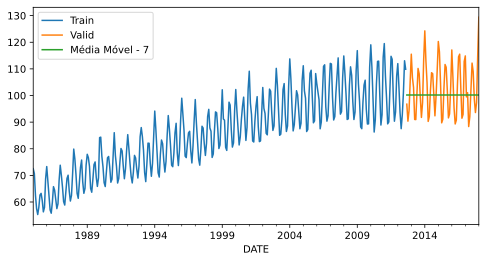

In [24]:
fig, ax = plt.subplots(figsize=(8,4))
train.plot(ax=ax)
valid.plot(ax=ax)
y_hat['m7'].plot(ax=ax)
ax.legend(['Train','Valid','Média Móvel - 7'])
plt.show()

Calculando o Erro da Média de 7 dias:

In [25]:
print('Erro da média móvel de 7 dias:')
mean_squared_error(y_hat.Value,y_hat.m7,squared=True)

Erro da média móvel de 7 dias:


101.21254960492308

Nosso erro já diminuiu circunstâncialmente!

## Aplicando a Holt's Linear Trend Model
Nas técnicas aplicadas anteriormente não podemos aplicar tendências, apenas nível das séries, mas com a Jolt's Linear Trend Model podemos aplicar tanto o nível quanto a tendência, e tende a obter melhores resultados que as técnicas utilizadas anteriormente!

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import Holt

Separando os componentes da Série Temporal:

In [27]:
result = seasonal_decompose(train)

Exibindo componentes:

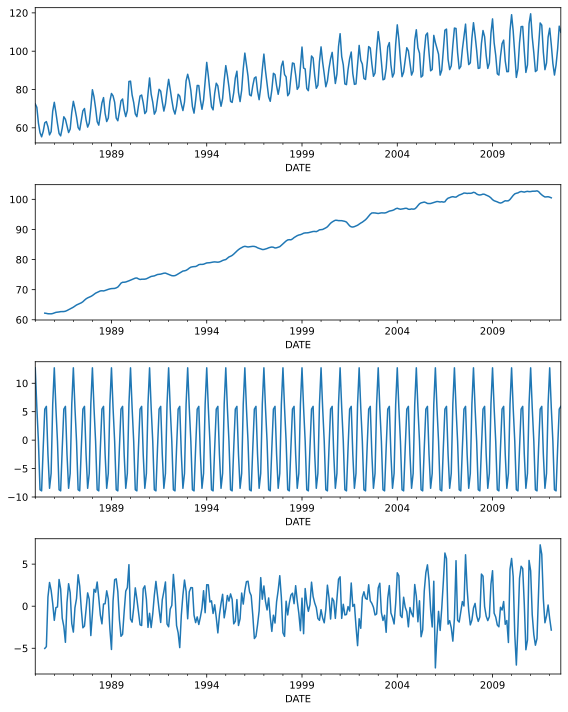

In [28]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(8,10))
result.observed.plot(ax=ax1)
result.trend.plot(ax=ax2)
result.seasonal.plot(ax=ax3)
result.resid.plot(ax=ax4)
plt.tight_layout()

Salvar os valorres para o dataset valid usando o Hols's:

In [29]:
y_hat['holt'] = Holt(train.Value).fit(smoothing_level=0.1,
                                      smoothing_slope=0.1).forecast(len(valid))

C:\Users\f48014593820\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\f48014593820\AppData\Local\Temp\ipykernel_17616\3669330900.py:1: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  y_hat['holt'] = Holt(train.Value).fit(smoothing_level=0.1,


Exibindo a train e a valid:

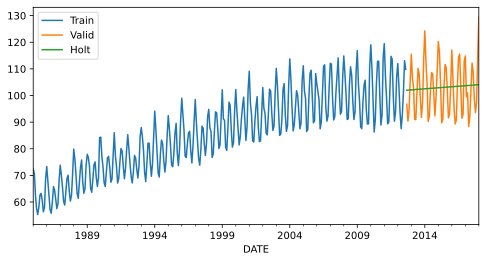

In [30]:
fig, ax = plt.subplots(figsize=(8,4))
train.plot(ax=ax)
valid.plot(ax=ax)
y_hat['holt'].plot(ax=ax)
ax.legend(['Train', 'Valid', 'Holt'])
plt.show()

Calculando o erro:

In [31]:
print("Erro do Holt's Linear Trend Model:")
mean_squared_error(valid.Value, y_hat.holt, squared=True)

Erro do Holt's Linear Trend Model:


93.79197449495196

Aqui nosso erro reduziu ainda mais!

## Visualizar Séries Temporais

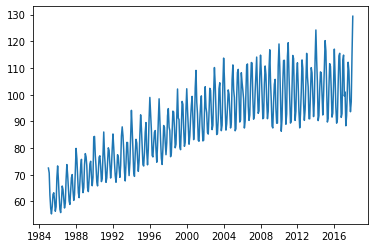

In [9]:
plt.plot(df.index,df.Value)

## 3. Decompondo a Time Series em seus componentes

É possível decompor uma série temporal se você considerar a série como uma combinação aditiva ou multiplicatia dos seus componentes.
A biblioteca stats from statsmodels.tsa.seasonal import seasonal_decompose

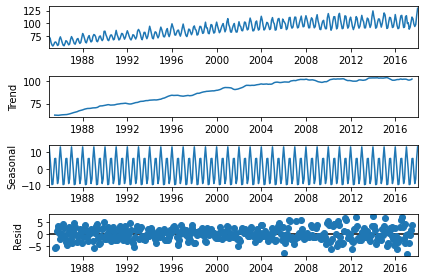

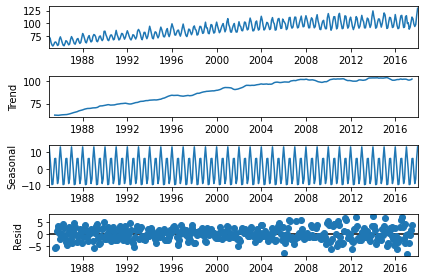

In [15]:
result = seasonal_decompose(df)
result.plot()

Melhorando a saida

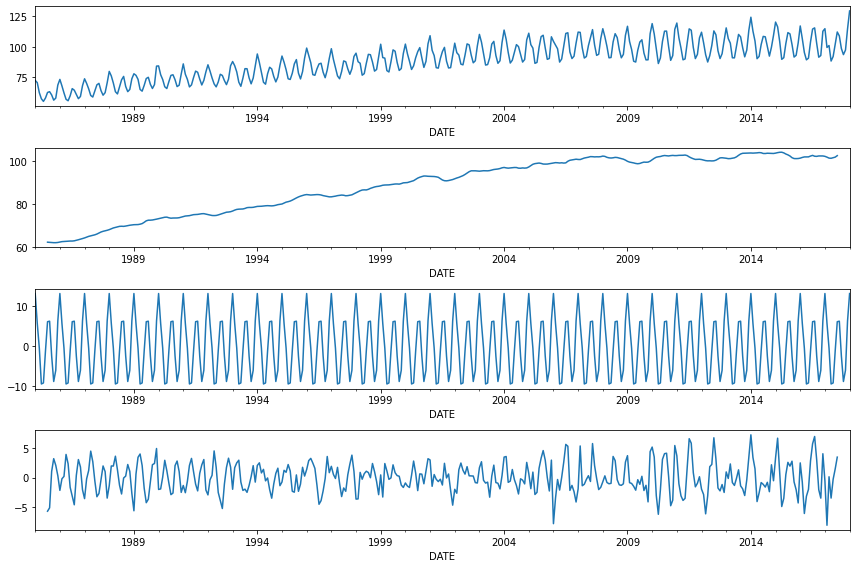

In [18]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(12,8))
result.observed.plot(ax=ax1)
result.trend.plot(ax=ax2)
result.seasonal.plot(ax=ax3)
result.resid.plot(ax=ax4)
plt.tight_layout()